## Retrieving and Indexing text into Pinecone (External_knowledge_NutritionInfo.csv)

<-> Before running this code, please sign up to get the api key on this website <br> https://www.pinecone.io/ <br>

### Option 1: use gemini ai - GoogleGenerativeAIEmbeddings for embedding model (free model from gemini: models/embedding-001) - SUCCESS

### PHASE-1

In [ ]:
!pip install -qU langchain langchain-community langchain-cohere langchain-pinecone langchain-google-genai google-generativeai

In [ ]:
!pip install --upgrade langchain-pinecone

In [ ]:
import pandas as pd
import numpy as np
from langchain.document_loaders import CSVLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Pinecone as LangChainPinecone
from pinecone import Pinecone, ServerlessSpec
import os
from typing import List, Dict
import json
import getpass
import os

In [ ]:
# Pinecone AUTH
api_key_pinecone = getpass.getpass("Input API KEY PINECONE CLOUD")
print('api_key_pinecone telah diinput')

Load CSV into Pandas

In [ ]:
# Add sheet label
df_nutrition["__sheet__"] = "NutritionInfo"
df_nutrition.head()

Convert Rows to Text for Embedding

In [ ]:
def row_to_text(row):
    sheet = str(row.get("__sheet__", "")).strip()

    if sheet == "NutritionInfo":
        return (
            f"Nutrition facts for {row.get('name', 'unknown')}: "
            f"{row.get('calories', 'N/A')} calories, "
            f"{row.get('protein_g', 'N/A')}g protein, "
            f"{row.get('carbohydrates_total_g', 'N/A')}g carbohydrates, "
            f"{row.get('fat_total_g', 'N/A')}g fat, "
            f"{row.get('fiber_g', 'N/A')}g fiber."
        )

    elif sheet == "Ingredient":
        return (
            f"Ingredient: {row.get('name', 'unknown')}. "
            f"Quantity: {row.get('quantity', 'unspecified')}. "
        )

    elif sheet == "Recipe":
        return (
            f"Recipe Title: {row.get('title', 'Untitled')}. "
            f"Description: {row.get('description', '')}. "
            f"Ingredients: {row.get('ingredients', '')}. "
            f"Instructions: {row.get('instructions', '')}. "
            f"Nutrition Score: {row.get('nutrition', 'unknown')}. "
        )

    return "Uncategorized entry."

# Apply to all rows
texts = df_nutrition.apply(row_to_text, axis=1).tolist()
metadatas = df_nutrition.to_dict(orient="records")

print(f"Converted {len(texts)} rows to documents.")

Setup Gemini AI Embedding Model

In [ ]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

In [ ]:
# Gemini AI AUTH
import getpass
import os

if not os.getenv("GOOGLE_API_KEY"):
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google API key: ")

In [ ]:
embedding_model = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

Chunk the Documents

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=300,
    chunk_overlap=50
)

chunks = []
chunk_metadata = []

for i, text in enumerate(texts):
    splits = text_splitter.split_text(text)
    chunks.extend(splits)
    chunk_metadata.extend([metadatas[i]] * len(splits))

Embedding and Store to Pinecone

In [ ]:
from langchain.vectorstores import Pinecone  # <--- THIS is LangChain's wrapper
import pinecone  # This is the official SDK
from time import sleep

In [ ]:
embeddings = embedding_model.embed_documents(texts)
print(f"Generated {len(embeddings)} embeddings.")

In [ ]:
# Initialize Pinecone
pinecone_api_key = "Input API KEY PINECONE"
pc = pinecone.Pinecone(api_key=pinecone_api_key)

index_name = "nutrition-rag-index"
spec = ServerlessSpec(
    cloud="aws", region="us-east-1"
)

existing_indexes = [index_info["name"] for index_info in pc.list_indexes()]

# Create vector index if not exist
if index_name not in existing_indexes:
    pc.create_index(
        name=index_name,
        dimension=768,
        metric='cosine',
        spec=spec
    )
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

# Connect to index
index = pc.Index(index_name)

Format Vectors + Metadata

In [ ]:
# Each entry must be a tuple of (id, vector, metadata)
vectors = [
    {
        "id": f"vec-{i}",
        "values": embeddings[i],
        "metadata": chunk_metadata[i]
    }
    for i in range(len(embeddings))
]

In [ ]:
# Batch upsert (up to 100 vectors per call is safe)
for i in range(0, len(vectors), 100):
    batch = vectors[i:i+100]
    index.upsert(vectors=batch)

print("Vector embeddings created successfully!")
print(f"Stored {len(texts)} document chunks with enhanced metadata")

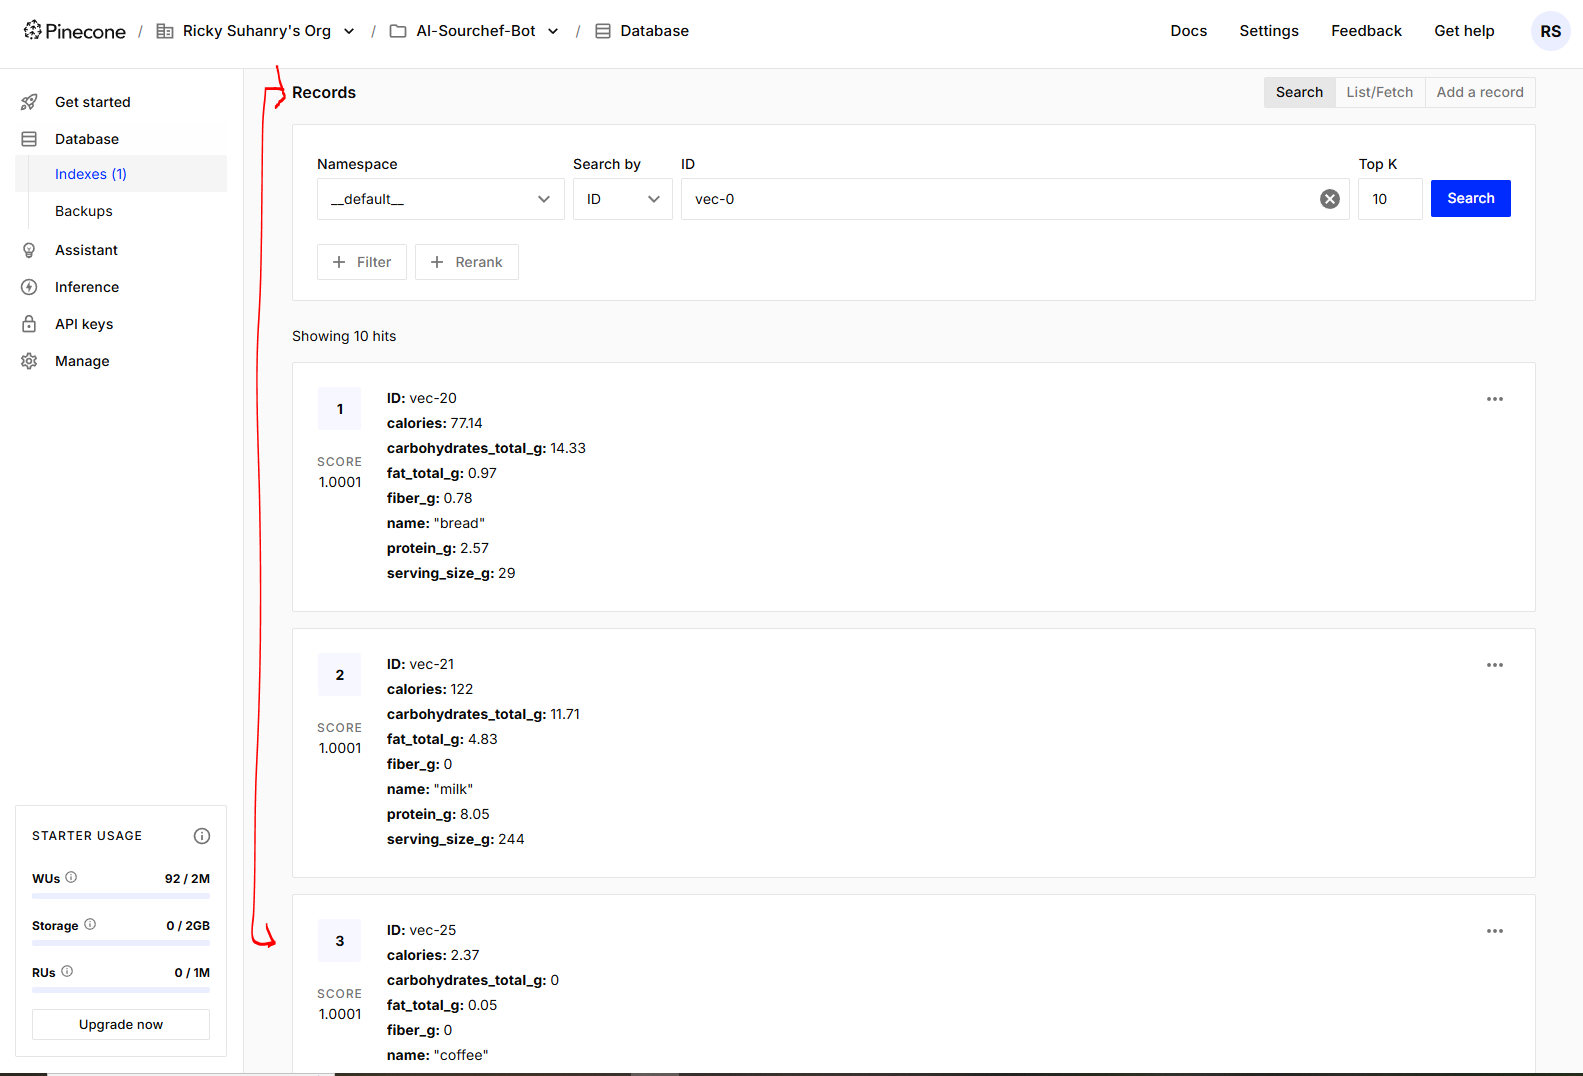

### PHASE-2

Search with LangChain Retriever

In [ ]:
retriever = vectorstore.as_retriever()

# Test query
results = retriever.get_relevant_documents("What is a healthy recipe with low carbs?")
for doc in results:
    print(doc.metadata["__sheet__"])
    print(doc.page_content)

RAG QA Chain Sample

In [ ]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash",
                             temperature=0,
                             max_tokens=None,
                             timeout=None,
                             temperature=0.3)

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    return_source_documents=True
)

response = qa_chain.run("Suggest a high-protein recipe with less than 500 calories.")
print(response)

### Option 2: use cohere - CohereEmbeddings for embedding model (paid model from cohere: models/embed-english-v3.0, but it's rate-limited and not intended for production use) - STILL FAILED

<-> Before running this code, please sign up to get the api key on this website <br> https://cohere.com/ <br> <-> Check detail info on other link: <br>
https://cohere.com/blog/free-developer-tier-announcement <br>
https://docs.cohere.com/v2/docs/rate-limits